In [73]:
import os
import pandas as pd
import numpy as np

import multiprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
import plotly.express as px
import plotly.graph_objects as go

In [74]:
# multiprocessed gridrearch algorithm for choosing optimal n_clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import trange

def get_silhouette_score(X_scaled, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    return (n_clusters, score)


def get_silhouette_score_gridsearch_multiprocess(X, min_clusters, max_clusters, scale=True, n_processes=None):

    # scale data
    if scale:
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = X.copy()

    # number of processes to use
    if not n_processes:
        n_processes = multiprocessing.cpu_count()

    # run grid search using multiprocessing
    pool = multiprocessing.Pool(processes=n_processes)
    results = pool.starmap(kmeans_utils.get_silhouette_score, [(X_scaled, n_clusters) for n_clusters in range(min_clusters, max_clusters + 1)])
    pool.close()
    pool.join()

    # find best k-means model
    best_score = float('-inf')
    best_kmeans = None
    for n_clusters, score in results:
        if score > best_score:
            best_score = score
            best_kmeans = KMeans(n_clusters=n_clusters, random_state=0)

    print(f"Best silhouette score: {best_score}")
    print(f"Best k-means model: {best_kmeans}")
    return results


def get_silhouette_score_gridsearch(X, min_clusters, max_clusters, scale=True):
    # scale data
    if scale:
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = X.copy()

    results = []
    # run grid search
    best_score = float('-inf')
    best_kmeans = None
    for n_clusters in trange(min_clusters, max_clusters + 1):
        score = get_silhouette_score(X_scaled, n_clusters)[1]
        if score > best_score:
            best_score = score
            best_kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        results.append((n_clusters, score))

    print(f"Best silhouette score: {best_score}")
    print(f"Best k-means model: {best_kmeans}")
    return results


# syntax sugar for better readability
def get_clasters(X, n_clusters, rs=0, scale=True):
    
    if scale:
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = X.copy()

    kmeans = KMeans(n_clusters=n_clusters)
    return kmeans.fit_predict(X_scaled)



def elbow_vis(X,title):

    sse={}

    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X)
        sse[k] = kmeans.inertia_

    px.line(
        x=list(sse.keys()), y=list(sse.values()),
        labels={
            'x':'N clusters',
        },
        title=title
    ).show()

#function for ordering cluster numbers
def sort_by_cluster(df,cluster_name, target_name, ascending):
    df_new = df.groupby(cluster_name, as_index=False)[target_name].mean()
    df_new = df_new.sort_values(by=target_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df, df_new[[cluster_name,'index']], on=cluster_name)
    df_final = df_final.drop([cluster_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_name})
    return df_final

In [62]:
# loading data 
folder_path = '/kaggle/input/brazilian-ecommerce'
customers_ = pd.read_csv(os.path.join(folder_path,"olist_customers_dataset.csv"))
order_items_ = pd.read_csv(os.path.join(folder_path,"olist_order_items_dataset.csv"))
order_payments_ = pd.read_csv(os.path.join(folder_path,"olist_order_payments_dataset.csv"))
orders_ = pd.read_csv(os.path.join(folder_path,"olist_orders_dataset.csv"))

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/brazilian-ecommerce\\olist_customers_dataset.csv'

In [75]:
# Loading the data 
customers_ = pd.read_csv(r'C:\Users\User\Brazilian E-commerce\Ungroup Brazilian Ecommerce\olist_customers_dataset.csv')
order_items_ = pd.read_csv(r'C:\Users\User\Brazilian E-commerce\Ungroup Brazilian Ecommerce\olist_order_items_dataset.csv')
order_payments_ = pd.read_csv(r'C:\Users\User\Brazilian E-commerce\Ungroup Brazilian Ecommerce\olist_order_payments_dataset.csv')
orders_ = pd.read_csv(r'C:\Users\User\Brazilian E-commerce\Ungroup Brazilian Ecommerce\olist_orders_dataset.csv')

In [76]:
orders_.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [77]:
df = (
    orders_
        .merge(order_items_, on='order_id')
        .merge(order_payments_, on='order_id')
        .merge(customers_, on='customer_id')
)
df.shape

(117601, 22)

In [78]:
df.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1245
order_delivered_customer_date    2567
order_estimated_delivery_date       0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
dtype: int64

In [79]:
# converting date columns to datetime
date_columns = ['shipping_limit_date', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

In [80]:
df['month_year'] = pd.to_datetime(df.order_purchase_timestamp.dt.strftime('%Y-%m-01'))

In [81]:
df.describe(include='all')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,month_year
count,117601,117601,117601,117601,117586,116356,115034,117601,117601.000000,117601,117601,117601,117601.000000,117601.000000,117601.000000,117601,117601.000000,117601.000000,117601,117601.000000,117601,117601,117601
unique,98665,98665,7,98111,90173,81016,95663,449,NaN,32951,3095,93317,NaN,NaN,NaN,4,NaN,NaN,95419,NaN,4110,27,24
top,895ab968e7bb0d5659d16cd74cd1650c,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-12-20 00:00:00,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,4a3ca9315b744ce9f8e9374361493884,2017-08-14 20:43:31,NaN,NaN,NaN,credit_card,NaN,NaN,9a736b248f67d166d2fbb006bcb877c3,NaN,sao paulo,SP,2017-11-01 00:00:00
freq,63,63,115035,63,63,63,63,649,NaN,536,2133,63,NaN,NaN,NaN,86769,NaN,NaN,75,NaN,18590,49566,9016
first,NaN,NaN,NaN,2016-09-04 21:15:19,2016-10-04 09:43:32,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-20 00:00:00,NaN,NaN,NaN,2016-09-19 00:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-09-01 00:00:00
last,NaN,NaN,NaN,2018-09-03 09:06:57,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00,NaN,NaN,NaN,2020-04-09 22:35:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-09-01 00:00:00
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.195900,NaN,NaN,NaN,120.824783,20.045990,1.093528,NaN,2.939482,172.686752,NaN,35051.793097,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.697706,NaN,NaN,NaN,184.479323,15.861315,0.726692,NaN,2.774223,267.592290,NaN,29820.588877,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.850000,0.000000,1.000000,NaN,0.000000,0.000000,NaN,1003.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,39.900000,13.080000,1.000000,NaN,1.000000,60.870000,NaN,11310.000000,NaN,NaN,NaN


In [82]:
df.isna().sum() / df.shape[0]

order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.000128
order_delivered_carrier_date     0.010587
order_delivered_customer_date    0.021828
order_estimated_delivery_date    0.000000
order_item_id                    0.000000
product_id                       0.000000
seller_id                        0.000000
shipping_limit_date              0.000000
price                            0.000000
freight_value                    0.000000
payment_sequential               0.000000
payment_type                     0.000000
payment_installments             0.000000
payment_value                    0.000000
customer_unique_id               0.000000
customer_zip_code_prefix         0.000000
customer_city                    0.000000
customer_state                   0.000000
month_year                       0.000000
dtype: float64

In [83]:
df = df.dropna()

In [84]:
px.bar(
    df.groupby('month_year', as_index=False)['customer_unique_id'].nunique().rename(columns={'customer_unique_id':'N users'}),
    x='month_year',
    y='N users',
    title='Monthly active customers dynamics'
).show()


px.bar(
    df.groupby('month_year', as_index=False)['order_id'].nunique().rename(columns={'order_id':'N orders'}),
    x='month_year',
    y='N orders',
    title='Monthly N orders dynamics'
).show()

px.bar(
    df.groupby('month_year', as_index=False)['payment_value'].mean().rename(columns={'payment_value':'ARPC'}),
    x='month_year',
    y='ARPC',
    title='ARPC dynamics'
).show()

In [85]:
df = df[df.month_year>='2017-01-01']

In [86]:
df.groupby('month_year', as_index=True)['order_id'].nunique() / \
df.groupby('month_year', as_index=True)['customer_unique_id'].nunique()

month_year
2017-01-01    1.044693
2017-02-01    1.014215
2017-03-01    1.015152
2017-04-01    1.012753
2017-05-01    1.019264
2017-06-01    1.019181
2017-07-01    1.018411
2017-08-01    1.019203
2017-09-01    1.016414
2017-10-01    1.013810
2017-11-01    1.014759
2017-12-01    1.011560
2018-01-01    1.013622
2018-02-01    1.024215
2018-03-01    1.012872
2018-04-01    1.008007
2018-05-01    1.008367
2018-06-01    1.006273
2018-07-01    1.009677
2018-08-01    1.006498
dtype: float64

In [87]:
df['fst_purchase_date'] = df.groupby('customer_unique_id').order_purchase_timestamp.transform('min')
df['is_fst_order'] =  df.order_purchase_timestamp == df['fst_purchase_date']

In [88]:
print(df.groupby([ 'is_fst_order'])['order_id'].nunique().to_frame() / df.order_id.nunique())

              order_id
is_fst_order          
False          0.02964
True           0.97036


In [89]:
print(df.groupby([ 'is_fst_order'])['payment_value'].sum().to_frame())
(df.groupby([ 'is_fst_order'])['payment_value'].sum()/ df['payment_value'].sum()).reset_index().rename(columns={'payment_value':'ratio'})

              payment_value
is_fst_order               
False             611101.07
True            19099682.36


,is_fst_order,ratio
0,False,0.031003
1,True,0.968997


In [90]:
px.line(
    (df.groupby(['month_year', 'is_fst_order'])['payment_value'].sum() / df.groupby(['month_year'])['payment_value'].sum()).reset_index().rename(columns={'payment_value':'ratio'}),
    x='month_year',
    y='ratio',
    color='is_fst_order'
 )

In [91]:
df[['order_id', 'payment_value', 'customer_unique_id', 'month_year', 'order_purchase_timestamp','order_item_id']].to_csv('df_for_rfm.csv', index=False)

In [92]:
df = pd.read_csv('df_for_rfm.csv')
for col in ['order_purchase_timestamp']:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')
df

,order_id,payment_value,customer_unique_id,month_year,order_purchase_timestamp,order_item_id
0,e481f51cbdc54678b7cc49136f2d6af7,18.12,7c396fd4830fd04220f754e42b4e5bff,2017-10-01 00:00:00,2017-10-02 10:56:33,1
1,e481f51cbdc54678b7cc49136f2d6af7,2.00,7c396fd4830fd04220f754e42b4e5bff,2017-10-01 00:00:00,2017-10-02 10:56:33,1
2,e481f51cbdc54678b7cc49136f2d6af7,18.59,7c396fd4830fd04220f754e42b4e5bff,2017-10-01 00:00:00,2017-10-02 10:56:33,1
3,53cdb2fc8bc7dce0b6741e2150273451,141.46,af07308b275d755c9edb36a90c618231,2018-07-01 00:00:00,2018-07-24 20:41:37,1
4,47770eb9100c2d0c44946d9cf07ec65d,179.12,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-01 00:00:00,2018-08-08 08:38:49,1
...,...,...,...,...,...,...
114676,63943bddc261676b46f01ca7ac2f7bd8,195.00,da62f9e57a76d978d02ab5362c509660,2018-02-01 00:00:00,2018-02-06 12:58:58,1
114677,83c1379a015df1e13d02aae0204711ab,271.01,737520a9aad80b3fbbdad19b66b37b30,2017-08-01 00:00:00,2017-08-27 14:46:43,1
114678,11c177c8e97725db2631073c19f07b62,441.16,5097a5312c8b157bb7be58ae360ef43c,2018-01-01 00:00:00,2018-01-08 21:28:27,1
114679,11c177c8e97725db2631073c19f07b62,441.16,5097a5312c8b157bb7be58ae360ef43c,2018-01-01 00:00:00,2018-01-08 21:28:27,2


In [93]:
df_users = df[['customer_unique_id']].drop_duplicates()

df['max_purchase_date'] = df.groupby('customer_unique_id').order_purchase_timestamp.transform('max')

df['Recency'] = (df['max_purchase_date'].max() - df['max_purchase_date']).dt.days


df_users = pd.merge(
    df_users,
    df[['customer_unique_id','Recency']].groupby(['customer_unique_id'],as_index=False).Recency.min(),
    on='customer_unique_id'
)

df_users.head()

,customer_unique_id,Recency
0,7c396fd4830fd04220f754e42b4e5bff,331
1,af07308b275d755c9edb36a90c618231,35
2,3a653a41f6f9fc3d2a113cf8398680e8,21
3,7c142cf63193a1473d2e66489a9ae977,283
4,72632f0f9dd73dfee390c9b22eb56dd6,196


In [94]:
df_users.Recency.describe()

count    93083.000000
mean       235.664117
std        150.901762
min          0.000000
25%        113.000000
50%        217.000000
75%        344.000000
max        601.000000
Name: Recency, dtype: float64

In [95]:
px.violin(x=df_users.Recency, title='Recency violin').show()
px.histogram(
    (df_users.groupby(['Recency']).customer_unique_id.nunique() / df_users.customer_unique_id.nunique()).reset_index(),
    x='Recency',
    y='customer_unique_id',
    title='Recency histogram'
    ).show()

In [96]:
elbow_vis(df_users[['Recency']],'Recency Elbow clusters')

In [97]:
get_silhouette_score_gridsearch(df_users[['Recency']].sample(20000,random_state=0),4,5,False)

100%|██████████| 2/2 [00:11<00:00,  5.55s/it]

Best silhouette score: 0.5666922213363305
Best k-means model: KMeans(n_clusters=5, random_state=0)


[(4, 0.5616601893007632), (5, 0.5666922213363305)]

In [98]:
#building 5 clusters for recency and adding it to dataframe
df_users[f'Recency_cluster'] = get_clasters(df_users[['Recency']], 5, 0, True)

df_users = sort_by_cluster(df_users,'Recency_cluster', 'Recency', False)

df_users.groupby('Recency_cluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
Recency_cluster,,,,,,,,
0,12166.0,501.291797,43.107701,436.0,464.0,494.0,535.0,601.0
1,15536.0,369.996910,35.046009,312.0,340.0,369.0,400.0,435.0
2,22243.0,254.475026,30.625399,202.0,226.0,259.0,278.0,311.0
3,23730.0,148.771597,30.129873,98.0,121.0,148.0,176.0,201.0
4,19408.0,46.305493,26.671795,0.0,23.0,42.0,70.0,97.0


In [99]:
df['n_order_items'] = df.groupby('order_id').order_item_id.transform('max')

In [100]:
px.line((df.groupby(['n_order_items'])['customer_unique_id'].count() / df['customer_unique_id'].count()))

In [101]:
n_items_per_user = df.groupby('customer_unique_id',as_index=False).n_order_items.sum().rename(columns={'n_order_items':'N_items'})# .describe()
df_users = df_users.merge(n_items_per_user, how='inner',on='customer_unique_id')

In [102]:
df_users.N_items.describe()

count    93083.000000
mean         1.715576
std          4.445670
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        441.000000
Name: N_items, dtype: float64

In [103]:
df_frequency = df.groupby('customer_unique_id', as_index=False).order_id.nunique().rename(columns={'order_id':"Frequency"})
df_frequency.columns = ['customer_unique_id','Frequency']

df_users = pd.merge(df_users, df_frequency, on='customer_unique_id')

In [104]:
df_users.Frequency.describe()

count    93083.000000
mean         1.033368
std          0.209011
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         15.000000
Name: Frequency, dtype: float64

In [105]:
elbow_vis(df_users[['Frequency']].copy(),'Frequency Elbow clusters')

In [106]:
get_silhouette_score_gridsearch(df_users[['Frequency']].sample(20000,random_state=0), 2, 5, True)

100%|██████████| 4/4 [00:20<00:00,  5.07s/it]

Best silhouette score: 0.9999
Best k-means model: KMeans(n_clusters=5, random_state=0)


[(2, 0.9956683417508402),
 (3, 0.9992176282051282),
 (4, 0.9997033455165693),
 (5, 0.9999)]

In [107]:
df_users[f'Frequency_cluster'] = get_clasters(df_users[['Frequency']], 5, 0, True)

df_users = sort_by_cluster(df_users,'Frequency_cluster', 'Frequency',True)

df_users.groupby('Frequency_cluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
Frequency_cluster,,,,,,,,
0,90295.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
1,2561.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
2,208.0,3.134615,0.342136,3.0,3.0,3.0,3.0,4.0
3,18.0,5.833333,1.098127,5.0,5.0,5.5,6.0,9.0
4,1.0,15.000000,NaN,15.0,15.0,15.0,15.0,15.0


In [108]:
elbow_vis(df_users[['N_items']].copy(),'N_items Elbow clusters')


In [109]:
get_silhouette_score_gridsearch(df_users[['N_items']].sample(20000,random_state=0),2,6,True)

100%|██████████| 5/5 [00:22<00:00,  4.53s/it]

Best silhouette score: 0.9960708392457398
Best k-means model: KMeans(n_clusters=2, random_state=0)


[(2, 0.9960708392457398),
 (3, 0.9687252796064291),
 (4, 0.9548011617605547),
 (5, 0.9254404544851806),
 (6, 0.9340727100657812)]

In [110]:
df_users[f'N_items_cluster'] = get_clasters(df_users[['N_items']], 2, 0, True)

df_users = sort_by_cluster(df_users,'N_items_cluster', 'N_items',True)

df_users.groupby('N_items_cluster')['N_items'].describe()

,count,mean,std,min,25%,50%,75%,max
N_items_cluster,,,,,,,,
0,93054.0,1.663217,2.895084,1.0,1.0,1.0,1.0,81.0
1,29.0,169.724138,92.757709,100.0,101.0,144.0,196.0,441.0


In [111]:
df_revenue = df.groupby('customer_unique_id', as_index=False).payment_value.sum().rename(columns={'payment_value':"Monetary"})

#merge it with our main dataframe
df_users = pd.merge(df_users, df_revenue, on='customer_unique_id')

In [112]:
elbow_vis(df_users[['Monetary']].copy(),
    title='Monetary Elbow clusters'
)

In [113]:
get_silhouette_score_gridsearch(df_users[['Monetary']].sample(20000,random_state=0),3,7,True)

100%|██████████| 5/5 [00:23<00:00,  4.65s/it]

Best silhouette score: 0.911920933058071
Best k-means model: KMeans(n_clusters=3, random_state=0)


[(3, 0.911920933058071),
 (4, 0.8367807843196637),
 (5, 0.8510683171586364),
 (6, 0.7777377313835472),
 (7, 0.7147167175881995)]

In [114]:
df_users[f'Monetary_cluster'] = get_clasters(df_users[['Monetary']], 3, 0, True)

df_users = sort_by_cluster(df_users,'Monetary_cluster', 'Monetary',True)

df_users.groupby('Monetary_cluster')['Monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
Monetary_cluster,,,,,,,,
0,92264.0,179.412659,214.103449,9.59,63.350,111.92,197.6425,1817.54
1,811.0,3464.950777,2548.628866,1821.82,2068.940,2570.48,3795.6700,22346.60
2,8.0,43422.343750,27648.337650,25051.89,28808.505,33337.62,44350.0000,109312.64


In [115]:
df_users.columns

Index(['customer_unique_id', 'Recency', 'Recency_cluster', 'N_items',
       'Frequency', 'Frequency_cluster', 'N_items_cluster', 'Monetary',
       'Monetary_cluster'],
      dtype='object')

In [116]:
df_users['OverallScore'] = df_users['Recency_cluster'] + df_users['Frequency_cluster'] + df_users['Monetary_cluster']
df_users.groupby(['OverallScore'])['Recency','Frequency','Monetary', 'N_items'].mean()

,Recency,Frequency,Monetary,N_items
OverallScore,,,,
0,501.426595,1.000000,171.400844,1.490411
1,373.040185,1.015918,199.581849,1.595538
2,257.454057,1.020833,194.148107,1.645242
3,152.537655,1.028698,209.454747,1.697317
4,51.353981,1.038990,219.482037,1.746132
5,58.619976,1.891596,1149.091157,7.380024
6,61.987013,3.168831,1926.893247,12.974026
7,78.100000,5.000000,2026.107000,16.200000
8,31.000000,8.000000,8412.910000,54.500000


In [117]:
df_users['OverallScore2'] = df_users['Recency_cluster'] + df_users['Frequency_cluster'] + df_users['Monetary_cluster'] + df_users['N_items_cluster']
df_users.groupby(['OverallScore2'])['Recency','Frequency','Monetary', 'N_items'].mean()

,Recency,Frequency,Monetary,N_items
OverallScore2,,,,
0,501.426595,1.000000,171.400844,1.490411
1,373.027009,1.015919,198.828625,1.580963
2,257.442104,1.020793,191.602771,1.606443
3,152.555787,1.028700,207.377774,1.685998
4,51.399283,1.038986,222.267536,1.763781
5,59.118149,1.891596,1101.018575,7.431181
6,64.073171,3.036585,2755.782561,22.292683
7,82.454545,4.727273,4119.360000,27.181818
8,34.333333,9.333333,1905.393333,24.666667


In [118]:
df_users = df_users.drop(columns=['OverallScore2', 'N_items', 'N_items_cluster'])

In [119]:
df_users.groupby(['OverallScore'])['Recency','Frequency','Monetary'].mean()

,Recency,Frequency,Monetary
OverallScore,,,
0,501.426595,1.000000,171.400844
1,373.040185,1.015918,199.581849
2,257.454057,1.020833,194.148107
3,152.537655,1.028698,209.454747
4,51.353981,1.038990,219.482037
5,58.619976,1.891596,1149.091157
6,61.987013,3.168831,1926.893247
7,78.100000,5.000000,2026.107000
8,31.000000,8.000000,8412.910000


In [120]:
get_silhouette_score_gridsearch(df_users[['OverallScore']], 3, 4, scale=False)

100%|██████████| 2/2 [03:07<00:00, 93.61s/it]

Best silhouette score: 0.8772663256406587
Best k-means model: KMeans(n_clusters=4, random_state=0)


[(3, 0.7118355538951763), (4, 0.8772663256406587)]

In [121]:
df_users[f'Segment'] = get_clasters(df_users[['OverallScore']], 4, 0, False)

df_users = sort_by_cluster(df_users,'Segment', 'OverallScore',True)

df_users.groupby('Segment')['OverallScore','Recency','Frequency','Monetary'].mean()

,OverallScore,Recency,Frequency,Monetary
Segment,,,,
0,0.565375,428.840187,1.008999,187.333667
1,2.000000,257.454057,1.020833,194.148107
2,3.000000,152.537655,1.028698,209.454747
3,4.049976,51.695154,1.084581,265.762982


In [122]:
print(df_users.groupby('Segment')['OverallScore','Recency','Frequency','Monetary'].mean())

         OverallScore     Recency  Frequency    Monetary
Segment                                                 
0            0.565375  428.840187   1.008999  187.333667
1            2.000000  257.454057   1.020833  194.148107
2            3.000000  152.537655   1.028698  209.454747
3            4.049976   51.695154   1.084581  265.762982


In [123]:
df_users['Segment']  = df_users['Segment'].map({
    0: 'Dormant',
    1: 'Casual',
    2: 'Active',
    3: 'Superior'
})

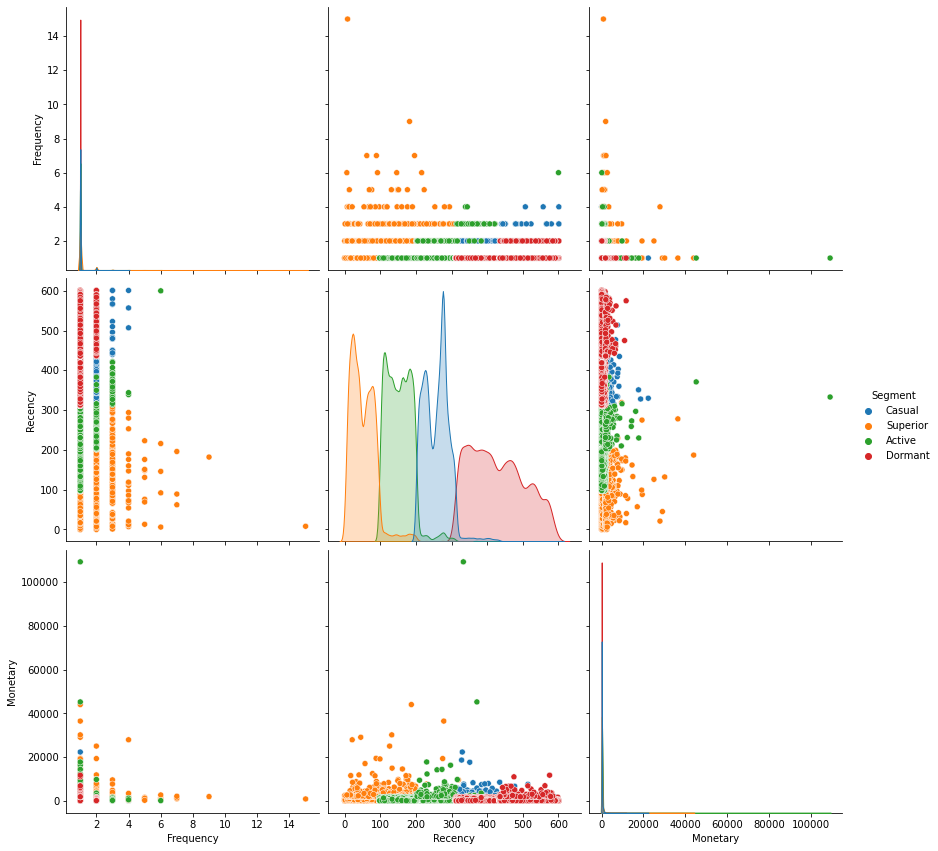

In [124]:
fig = px.scatter_matrix(df_users,
                        dimensions = ['Recency', 'Frequency','Monetary'],
                        color = 'Segment',
                        symbol = 'Segment',
                        # mapbox_style = "stamen-watercolor",
                        # color_discrete_map = dict(red= 1, blue=0),
                        width=1000, height=1000
                        )
fig.update_traces(diagonal_visible=True)
fig.show()

import seaborn as sns
sns.pairplot(data=df_users[['Frequency', 'Recency', 'Monetary', 'Segment']], hue='Segment', height=4, )

In [54]:
import plotly.io as pio
pio.renderers.default = 'browser'

fig = px.scatter_matrix(df_users,
                        dimensions = ['Recency', 'Frequency','Monetary'],
                        color = 'Segment',
                        symbol = 'Segment',
                        # mapbox_style = "stamen-watercolor",
                        # color_discrete_map = dict(red= 1, blue=0),
                        width=1000, height=1000
                        )
fig.update_traces(diagonal_visible=True)
fig.show()


# very heavy visualisation! Run only on powerful hardware)

import plotly.figure_factory as ff
fig = ff.create_scatterplotmatrix(
    df_users[['Recency', 'Frequency','Monetary', 'Segment']],
    index = 'Segment',
    diag='box',
    width=900, height=900
)
fig.show()

KeyError: 'Segment'

KeyError: 'Segment'

KeyError: 'your_segment_column_name'